# Gachon: Preprocessing + EDA of second language learners' corpus data

Basic NLP preprocessing steps + feature engineering. Corpus: Gachon - http://koreanlearnercorpusblog.blogspot.com/p/corpus.html

In [3]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from spellchecker import SpellChecker
import sys
import seaborn as sns
sys.path.append("../movielingo/")
%load_ext autoreload
%autoreload 2

In [4]:
from movielingo.config import gachon_dir, processed_data_dir
raw_directory = gachon_dir
raw_filename = "Gachon Learner Corpus - Final Version.xlsx"
raw_filepath = raw_directory / raw_filename
processed_directory = processed_data_dir
processed_filename = '01_gachon_processed.csv' # file to be saved after data cleaning
processed_filepath = processed_directory / processed_filename

In [7]:
gachon = pd.read_excel(raw_filepath)

In [9]:
check_if_numeric = lambda x: str(x).isdigit()

In [10]:
gachon["toeic_good"] = gachon['TOEIC Score 토익 점수'].apply(check_if_numeric)
print(gachon[gachon.toeic_good == 0]['TOEIC Score 토익 점수'].unique())

['x' 'X' '×' '270~300']


In [11]:
gachon.at[(gachon['TOEIC Score 토익 점수'] == '270~300'), 'TOEIC Score 토익 점수'] = np.median((270,300))

In [12]:
gachon["toeic_good"] = gachon['TOEIC Score 토익 점수'].apply(check_if_numeric)

In [13]:
print(gachon[gachon.toeic_good == 0]['TOEIC Score 토익 점수'].unique())

['x' 'X' '×' 285.0]


In [14]:
gachon = gachon[gachon.toeic_good == 1].copy()

In [15]:
gachon.rename(columns={'TOEIC Score 토익 점수': "toeic", "Student number:": "student",
                               "Please answer the following question. Write between 100 and 150 words. 다음 질문에 100~150단어 답해주십시오.":
                               "text"}, inplace = True)

In [20]:
gachon_relevant = gachon[['student','text','toeic']]
gachon_relevant.loc[:,'student'] = gachon_relevant.student.astype(str).copy() + '_' + gachon_relevant.toeic.astype(str).copy()

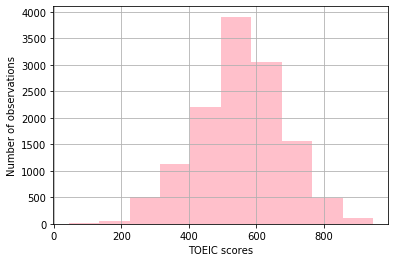

In [21]:
gachon_relevant.toeic.hist(color = 'pink')
plt.xlabel('TOEIC scores')
plt.ylabel('Number of observations');

In [22]:
print('Number of students:', len(gachon_relevant.student.unique()))

Number of students: 1528


#### TOEIC to CEFR conversion:
- 120-254 - A1
- 255-549 - A2
- 550-784 - B1
- 785-944 - B2
- 945-... - C1

https://www.yumpu.com/en/document/read/11409349/correlation-table-toeicr-listening-and-reading-scores

In [23]:
def toeic2cefr(row):
    if row.toeic < 120:
        return None
    elif row.toeic < 255:
        return 'A1'
    elif row.toeic < 550:
        return 'A2'
    elif row.toeic < 785:
        return 'B1'
    elif row.toeic < 945:
        return 'B2'
    elif row.toeic > 944:
        return 'C1'
    else:
        return None

In [26]:
cefr_scores = gachon_relevant.apply(toeic2cefr, axis = 1).copy()
gachon_relevant.loc[:,'cefr'] = cefr_scores.copy()

Reading some texts here to get a better sense of them

In [57]:
text_index = 900
print(gachon_relevant.text.iloc[text_index])
print('toeic:', gachon_relevant.toeic.iloc[text_index])
print('cefr:', gachon_relevant.cefr.iloc[text_index])

My most hate aggressive driving is Cut in my road.
When I beginner level driver, I drive to mart. It was 12:00 pm. It was very bright, not dark. And road is not crowded. No traffic jam.
It was vest day for beginner driver…but when I go back to home, run left side big car had cut in my front.
I push my break, and i almost dead. And I have trauma drive to out.
Cut in is very dengerous driving. It was cause accident. I think, someone have care for other driver, don’t cut in other car’s front.
And you must have cut in, you turn on light and give a sing ‘I’ll have cut in your front. It’s OK?’
toeic: 440
cefr: A2


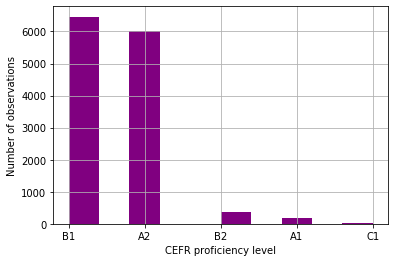

In [27]:
gachon_relevant.cefr.hist(color = 'purple')
plt.xlabel('CEFR proficiency level')
plt.ylabel('Number of observations');

In [28]:
gachon_relevant.to_csv(processed_filepath)

In [31]:
import movielingo.text_utils
import movielingo.single_text_processor
from movielingo.batch_text_processing_multi import create_df_from_texts

In [32]:
df = create_df_from_texts(processed_filename) # this can take from 12 min to 5 hours depending on your machine

13029it [00:00, 14340.67it/s]
  7%|▋         | 976/13028 [08:14<1:41:42,  1.97it/s] Process ForkPoolWorker-2:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/insight/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/insight/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/insight/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "../movielingo/movielingo/batch_text_processing_multi.py", line 35, in process_one_text
    features = engineer_features_v2(l2_dict)

Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/insight/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-4:
  File "/opt/anaconda3/envs/insight/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*

KeyboardInterrupt: 

  File "../movielingo/movielingo/single_text_processor.py", line 87, in <listcomp>
    self.words = [get_corrected_word(word) for word in words_uncorrected]
  File "../movielingo/movielingo/text_utils.py", line 32, in get_corrected_word
    return SPELL.correction(unknown[0])
  File "/opt/anaconda3/envs/insight/lib/python3.7/site-packages/spellchecker/spellchecker.py", line 148, in correction
    candidates = list(self.candidates(word))
  File "/opt/anaconda3/envs/insight/lib/python3.7/site-packages/spellchecker/spellchecker.py", line 169, in candidates
    tmp = self.known([x for x in self.__edit_distance_alt(res)])
  File "/opt/anaconda3/envs/insight/lib/python3.7/site-packages/spellchecker/spellchecker.py", line 258, in __edit_distance_alt
    return [e2 for e1 in tmp for e2 in self.edit_distance_1(e1)]
  File "/opt/anaconda3/envs/insight/lib/python3.7/site-packages/spellchecker/spellchecker.py", line 258, in <listcomp>
    return [e2 for e1 in tmp for e2 in self.edit_distance_1(e1)

In [21]:
df.to_csv('../data/processed/02_gachon_features.csv', index = False)

In [33]:
df = pd.read_csv(processed_directory / '02_gachon_features.csv')

In [34]:
df.head()

,text_id,L2_proficiency,n_uniq_lemmas,mean_sent_len,median_sent_len,sd_sent_len,mean_word_len,mean_wf_lemma,mean_wf_token,n_unique_verb_forms,n_unique_past_verbs,n_unique_adj,n_unique_adv,n_unique_prepos,n_unique_modals,n_wh
0,21011008_780,780,3.8125,13.125000,12.5,3.479853,105.0,-6.839067,-6.886171,0.047619,0.028571,0.085714,0.057143,6,2,3
1,21011008_780,780,3.9375,14.571429,15.0,3.886134,102.0,-6.838168,-6.826438,0.058824,0.029412,0.068627,0.068627,9,1,1
2,21011008_780,780,3.6250,17.200000,15.0,6.584831,86.0,-6.871108,-6.902001,0.069767,0.069767,0.081395,0.058140,9,1,3
3,21011008_780,780,3.5625,15.000000,16.0,4.035556,105.0,-6.891807,-6.938099,0.038095,0.038095,0.076190,0.028571,10,3,4
4,21011008_780,780,3.6875,13.625000,10.5,6.081478,109.0,-7.128087,-7.071439,0.045872,0.036697,0.055046,0.082569,6,3,0


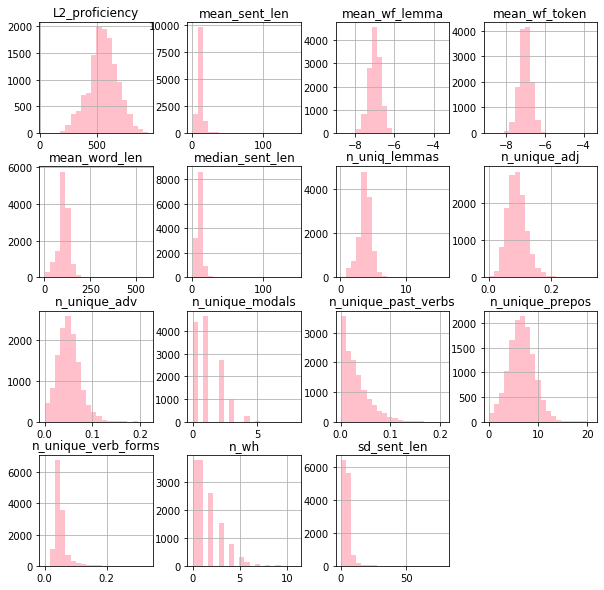

In [36]:
df.hist(figsize = (10,10), bins = 20, color = 'pink');

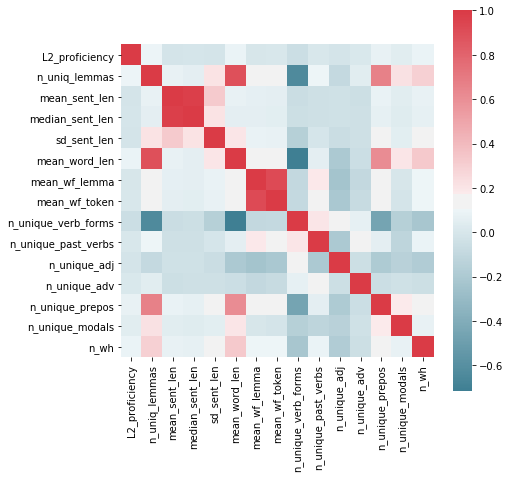

In [38]:
f, ax = plt.subplots(figsize=(7, 7))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax);